In [115]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import yfinance as yf
from IPython.display import display, clear_output
import pandas as pd

In [119]:
#stocks_list = ["AAPL", "GOOGL", "MSFT", "AMZN", "META", "TSLA", "NVDA", "PYPL", "ADBE", "INTC"]
# df = pd.DataFrame()
# for stock in stocks_list:
#     data = yf.download(stock, period="600d", interval="1h")
#     y = data["Adj Close"].values
#     y = y[:4000]
#     df[stock] = y
# df.head()
# write dataframe to csv
#df.to_csv("stocks.csv")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,GOOGL,MSFT,AMZN,META,TSLA,NVDA,PYPL,ADBE,INTC
0,146.119995,141.664001,297.760010,170.164352,347.785004,251.682846,219.745300,276.744995,623.440002,54.301601
1,145.899994,141.414001,297.109985,169.750000,346.959991,253.522629,218.659897,275.119995,619.239990,54.110001
2,146.565002,141.849503,298.299988,170.517181,352.059998,254.071960,220.835999,276.080109,622.054993,54.229900
3,146.780106,141.705505,298.640015,170.694000,352.709991,255.510025,221.444504,276.500000,622.780029,54.285000
4,146.829895,141.566498,298.160004,170.199997,351.869995,256.149994,219.936493,275.869995,620.450012,54.224998


In [144]:
y = pd.read_csv("stocks.csv", index_col=0)

<Figure size 2000x1000 with 0 Axes>

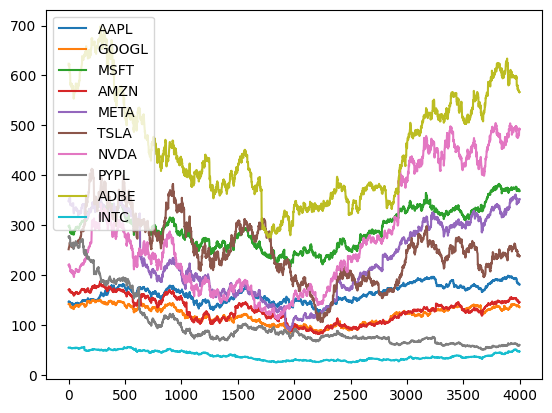

In [151]:
plt.figure(figsize=(20, 10))
y.plot()
plt.legend(loc='upper left')
plt.show()

In [68]:
class Model(nn.Module):

    # FITS: Frequency Interpolation Time Series Forecasting
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.individual = configs.individual
        self.channels = configs.enc_in

        self.dominance_freq=configs.cut_freq 
        self.length_ratio = (self.seq_len + self.pred_len)/self.seq_len

        if self.individual:
            self.freq_upsampler = nn.ModuleList()
            for i in range(self.channels):
                self.freq_upsampler.append(nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat))

        else:
            self.freq_upsampler = nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat)


    def forward(self, x):
        # RIN
        x_mean = torch.mean(x, dim=1, keepdim=True)
        x = x - x_mean
        x_var=torch.var(x, dim=1, keepdim=True)+ 1e-5
        x = x / torch.sqrt(x_var)

        low_specx = torch.fft.rfft(x, dim=1)
        low_specx[:,self.dominance_freq:]=0 # LPF
        low_specx = low_specx[:,0:self.dominance_freq,:] # LPF
        if self.individual:
            low_specxy_ = torch.zeros([low_specx.size(0),int(self.dominance_freq*self.length_ratio),low_specx.size(2)],dtype=low_specx.dtype).to(low_specx.device)
            for i in range(self.channels):
                low_specxy_[:,:,i]=self.freq_upsampler[i](low_specx[:,:,i].permute(0,1)).permute(0,1)
        else:
            low_specxy_ = self.freq_upsampler(low_specx.permute(0,2,1)).permute(0,2,1)
        low_specxy = torch.zeros([low_specxy_.size(0),int((self.seq_len+self.pred_len)/2+1),low_specxy_.size(2)],dtype=low_specxy_.dtype).to(low_specxy_.device)
        low_specxy[:,0:low_specxy_.size(1),:]=low_specxy_ 
        low_xy=torch.fft.irfft(low_specxy, dim=1)
        low_xy=low_xy * self.length_ratio 
        xy=(low_xy) * torch.sqrt(x_var) +x_mean
        return xy, low_xy* torch.sqrt(x_var)



In [136]:
@dataclass
class Config:
    seq_len: int = 100
    pred_len: int = 20 
    individual: bool = True
    enc_in: int = 10 # input features
    cut_freq: int = 25

config = Config()

model=Model(config)
for param in model.parameters():
    param.data.fill_(0)
import torchinfo
print(torchinfo.summary(model))
x = torch.randn(1, 100, 10)
print()
print(model.forward(x)[0].shape)

Layer (type:depth-idx)                   Param #
Model                                    --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       780
│    └─Linear: 2-2                       780
│    └─Linear: 2-3                       780
│    └─Linear: 2-4                       780
│    └─Linear: 2-5                       780
│    └─Linear: 2-6                       780
│    └─Linear: 2-7                       780
│    └─Linear: 2-8                       780
│    └─Linear: 2-9                       780
│    └─Linear: 2-10                      780
Total params: 7,800
Trainable params: 7,800
Non-trainable params: 0

torch.Size([1, 120, 10])


/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/module.py:1148: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


In [137]:
model_optim = optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.MSELoss()

In [146]:
def train(model: nn.Module, config: dataclass, epochs: int = 1000):

    for epoch in tqdm(range(epochs), desc='Training Progress'):
        order = np.random.permutation(2000)
        train_loss = []
        for batch in range(25):
            batch_start = order[batch*80:(batch+1)*80]
            batch = []
            for i in batch_start:
                batch.append(y[i:i+config.seq_len+config.pred_len])
                
            batch_xy = np.array(batch).reshape(80, config.seq_len+config.pred_len, 10)
            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :config.seq_len, :]
            batch_y = batch_xy[:, config.seq_len:, :]

            model_optim.zero_grad()

            output, _ = model(batch_x)

            loss = criterion(output, batch_xy)

            train_loss.append(loss.item())

            loss.backward()

            model_optim.step()

        clear_output(wait=True)
        display(f'Epoch: {epoch} Loss: {np.mean(train_loss)}')

    clear_output(wait=True)
    display(f'Final Epoch: {epoch} Loss: {np.mean(train_loss)}')

    output=output.cpu().detach().numpy()
    batch_xy=batch_xy.cpu().detach().numpy()
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(output[0,:,0], label="Prediction")
    plt.plot(batch_xy[0,:,0],'--', label="Ground Truth")
    plt.axvline(config.seq_len, color='r', linestyle='--', label="Train-Test Split")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(output[1,:,0], label="Prediction")
    plt.plot(batch_xy[1,:,0], '--', label="Ground Truth")
    plt.axvline(config.seq_len, color='r', linestyle='--', label="Train-Test Split")
    plt.legend()
    plt.show()

train(model, Config())

'Epoch: 27 Loss: 37.284249267578126'

KeyboardInterrupt: 